# Hate Speech Detector 2.0
---
**Deep Learning classifier hyperparameters analysis**

1. Load lemmatized tweets.
2. Load best vectorizer (**pretrained Word2Vec CBoW vectorizer**).
3. Use the best DL models trained in previous tasks (**1d CNN** - *32 chan.; 3-sized kernel; 2 conv. layers*). Research hyperparameters: regularization, optimizer, optimizer scheduler with appropriate parameters.
4. Perform multilabel classification task.
5. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
6. Perform some test on independent sanitized tweets about polish courts.

**Class weight types**
1. (0) --> 1/(class card.)
2. (1) --> (all examples card.)/(class card.)
3. (2) --> 2 - (class card.)/(all examples card.)
4. (n) --> 1

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch

from src.classifiers.DLVectorClassifier import DLVectorClassifier
from src.vectorizers.WordPretrainedVectorizer import WordPretrainedVectorizer
from src.nn.models import Conv1dNet
from src.dataframes.utils import combine_row_wisely, shuffle_dataframe, class_weights
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import (LABELS, DUPLICATED_PATH, LEMMAS_PATH,
                           DLHP_CHART_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
WEIGHT_TYPE = 2

In [4]:
plt.style.use('ggplot')

## Data loading

### Classes

In [5]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [6]:
df_lemmatized = pd.read_csv(LEMMAS_PATH).drop(['id'], axis=1)
df_lemmatized.head(2)

,lemmatized
0,w czwartek musieć poprawić sąd i trybunał
1,żale nałęcz i riposta macierewicz pan być w ko...


### Combined data

In [7]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,lemmatized,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
5925,po prosty podejrzewać pani o gołosłowność co u...,0,0,0,0,0,0,0
7412,pani wiedzieć dobrze po co więc sąd .w iv rp j...,0,0,0,0,0,0,0


### Class weights

In [8]:
weights = class_weights(df_classes, w_type=WEIGHT_TYPE)
wlabel = f'w{WEIGHT_TYPE}'
mlabel = 'c1d'
weights

array([1.96630992, 1.95459439, 1.9713761 , 1.9734659 , 1.9341397 ,
       1.93059338, 1.99620037])

## Models implementation and testing

In [9]:
HYPERPARAMS = [{'_optim': torch.optim.AdamW, '_optim_params': dict({'amsgrad': False}),
                '_sched': torch.optim.lr_scheduler.ReduceLROnPlateau, '_sched_params': dict({'patience': 5, 'factor': 0.97}),},
               {'_optim': torch.optim.AdamW, '_optim_params': dict({'amsgrad': True}),
                '_sched': torch.optim.lr_scheduler.ReduceLROnPlateau, '_sched_params': dict({'patience': 5, 'factor': 0.97}),},
               {'_optim': torch.optim.AdamW, '_optim_params': dict({'lr': 0.01, 'amsgrad': False}),
                '_sched': torch.optim.lr_scheduler.CyclicLR, '_sched_params': dict({'base_lr': 0.001, 'max_lr': 0.01, 'cycle_momentum': False}),},
               {'_optim': torch.optim.AdamW, '_optim_params': dict({'lr': 0.01, 'amsgrad': True}),
                '_sched': torch.optim.lr_scheduler.CyclicLR, '_sched_params': dict({'base_lr': 0.001, 'max_lr': 0.01, 'cycle_momentum': False}),},
               {'_optim': torch.optim.AdamW, '_optim_params': dict({'lr': 0.01, 'amsgrad': False}),
                '_sched': torch.optim.lr_scheduler.OneCycleLR, '_sched_params': dict({'max_lr': 0.001, 'steps_per_epoch': 60, 'epochs': 50, 'cycle_momentum': False}),},
               {'_optim': torch.optim.AdamW, '_optim_params': dict({'lr': 0.01, 'amsgrad': True}),
                '_sched': torch.optim.lr_scheduler.OneCycleLR, '_sched_params': dict({'max_lr': 0.001, 'steps_per_epoch': 60, 'epochs': 50, 'cycle_momentum': False}),},
               
               {'_optim': torch.optim.SGD, '_optim_params': dict({'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.01}),
                '_sched': torch.optim.lr_scheduler.ReduceLROnPlateau, '_sched_params': dict({'patience': 5, 'factor': 0.97}),},
               {'_optim': torch.optim.SGD, '_optim_params': dict({'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.01}),
                '_sched': torch.optim.lr_scheduler.CyclicLR, '_sched_params': dict({'base_lr': 0.01, 'max_lr': 0.1, 'mode': 'triangular'}),},
               {'_optim': torch.optim.SGD, '_optim_params': dict({'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.01}),
                '_sched': torch.optim.lr_scheduler.CyclicLR, '_sched_params': dict({'base_lr': 0.01, 'max_lr': 0.1, 'mode': 'triangular2'}),},
               {'_optim': torch.optim.SGD, '_optim_params': dict({'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.01}),
                '_sched': torch.optim.lr_scheduler.CyclicLR, '_sched_params': dict({'base_lr': 0.01, 'max_lr': 0.1, 'mode': 'exp_range'}),},
               {'_optim': torch.optim.SGD, '_optim_params': dict({'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.01}),
                '_sched': torch.optim.lr_scheduler.OneCycleLR, '_sched_params': dict({'max_lr': 0.001, 'steps_per_epoch': 60, 'epochs': 50, 'cycle_momentum': False}),},
               {'_optim': torch.optim.SGD, '_optim_params': dict({'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.01}),
                '_sched': torch.optim.lr_scheduler.OneCycleLR, '_sched_params': dict({'max_lr': 0.001, 'steps_per_epoch': 60, 'epochs': 50}),},
               ]
for hparams in HYPERPARAMS:
    hparams['_epochs'] = 50
HYPERPARAM_LABELS = ['adamw-noams-rop', 'adamw-ams-rop', 'adamw-noams-cyc', 'adamw-ams-cyc', 'adamw-noams-ocy', 'adamw-ams-ocy',
                     'sgd-rop', 'sgd-cyc-tri', 'sgd-cyc-tri2', 'sgd-cyc-exp', 'sgd-ocy-nocm', 'sgd-ocy-cm',
                     ]

In [10]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

y_preds = list([])

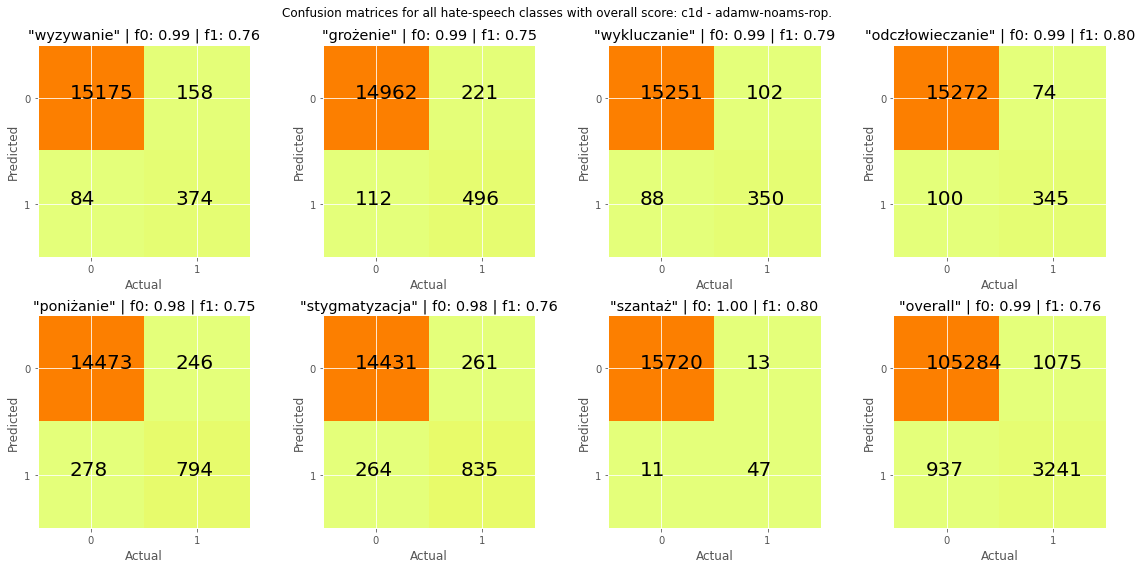

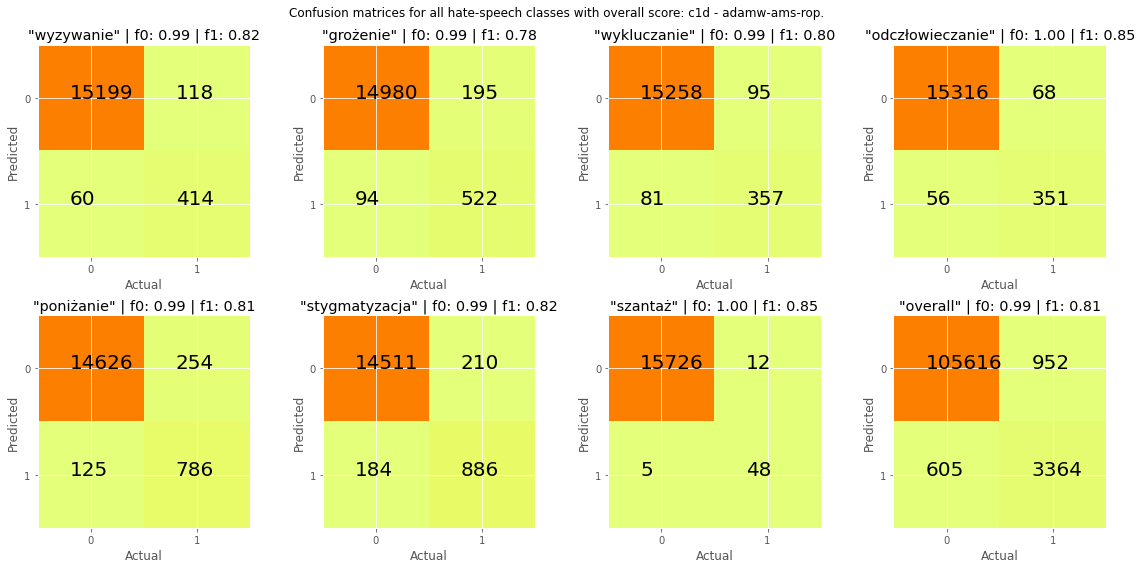

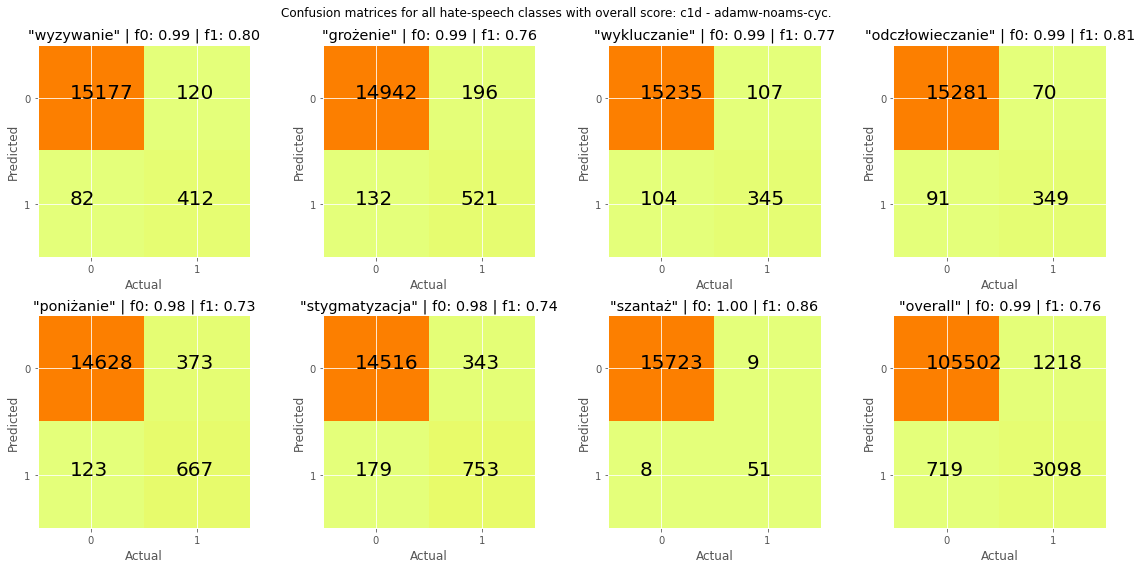

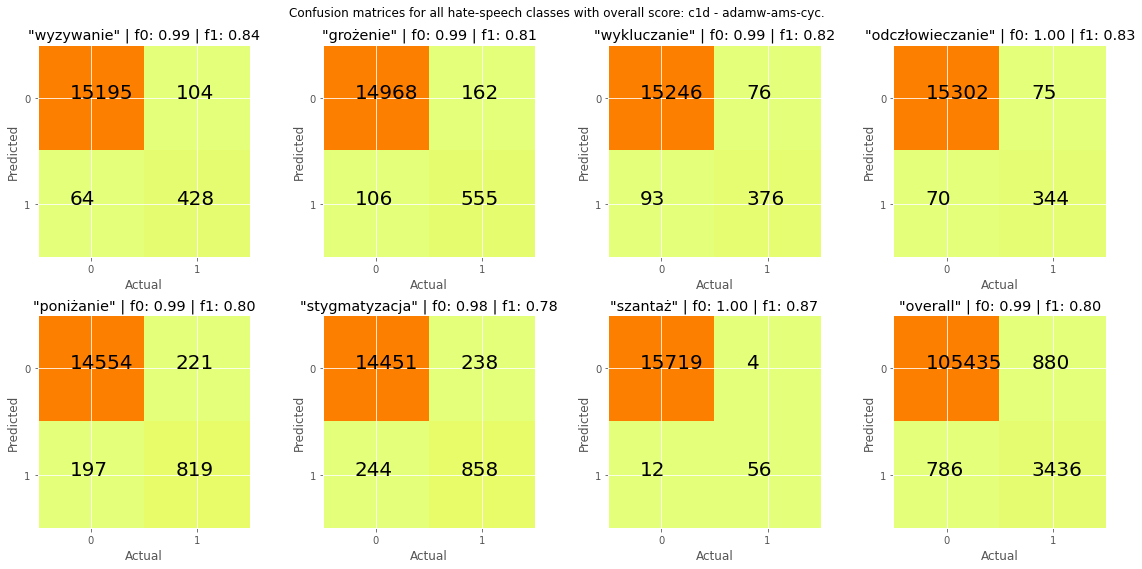

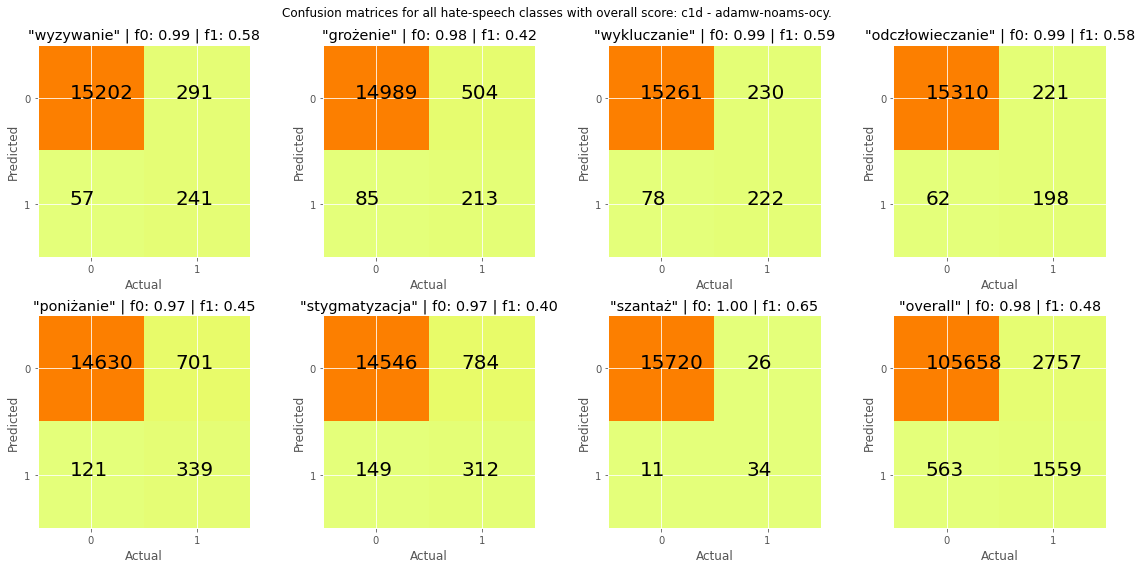

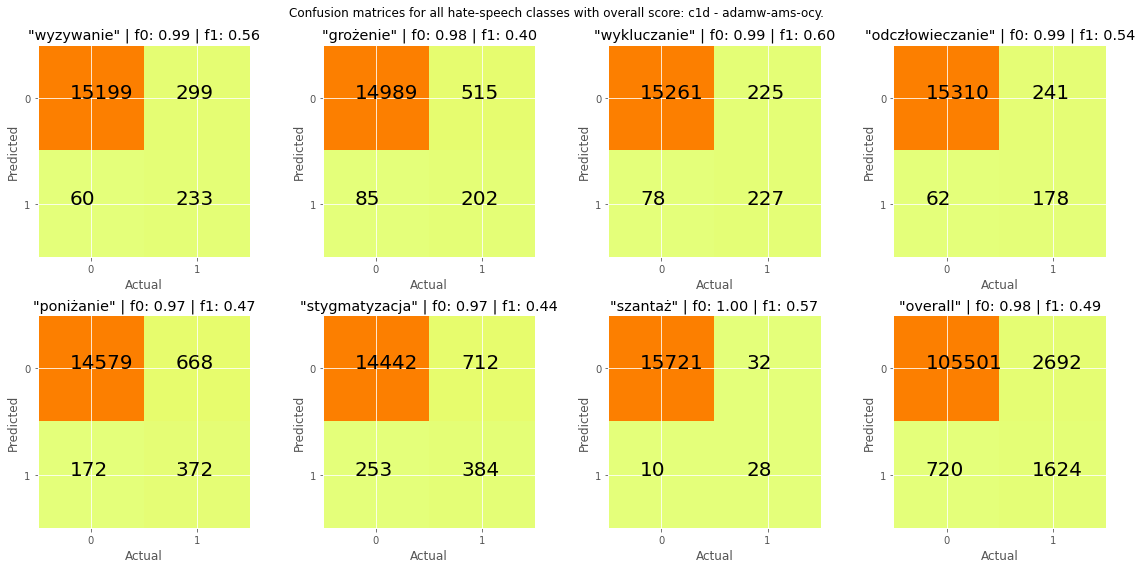

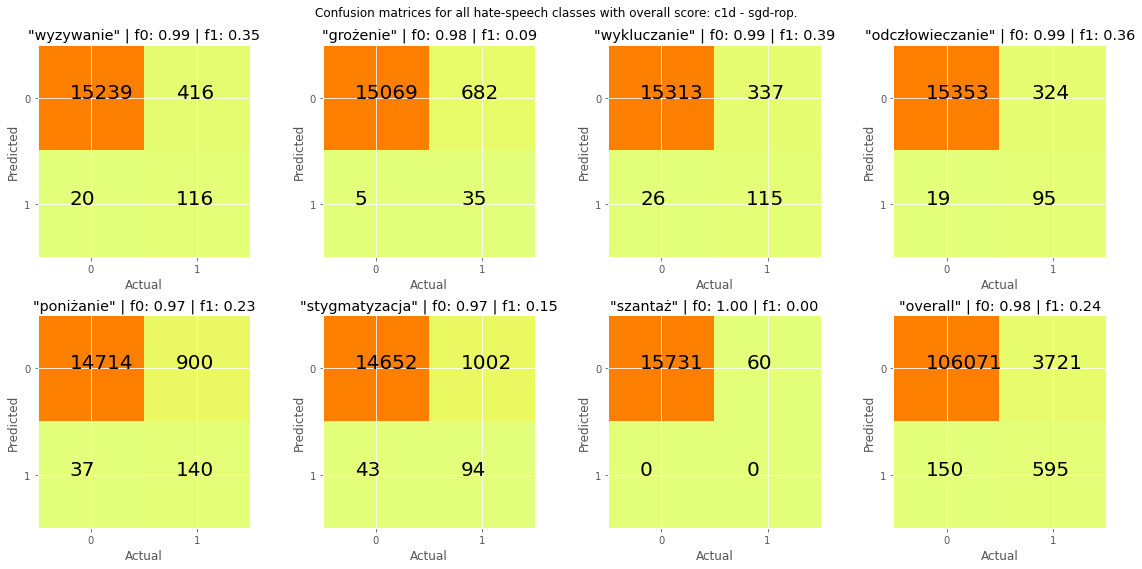

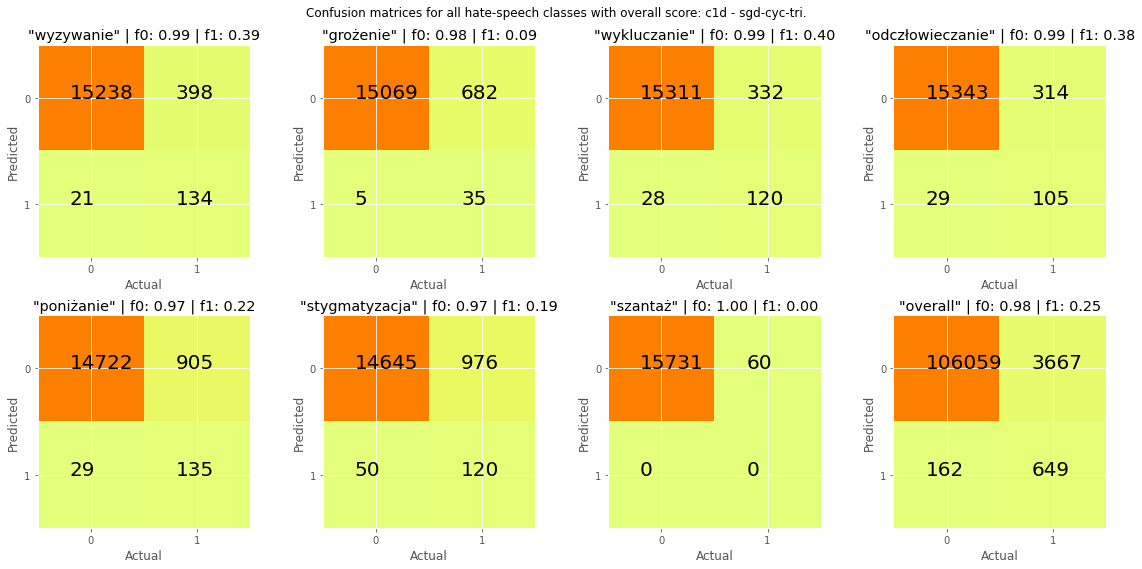

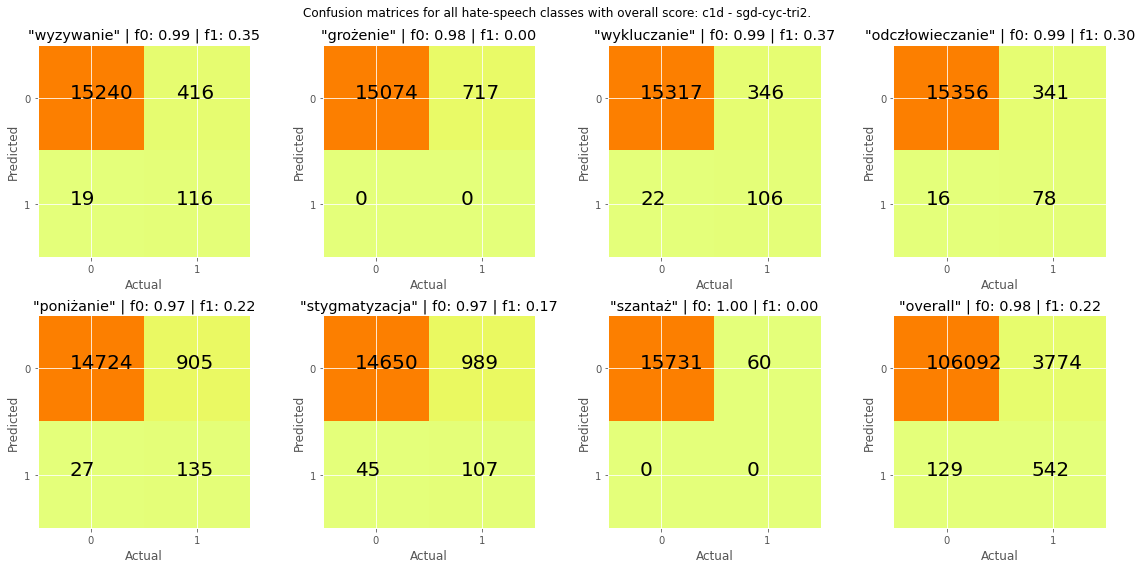

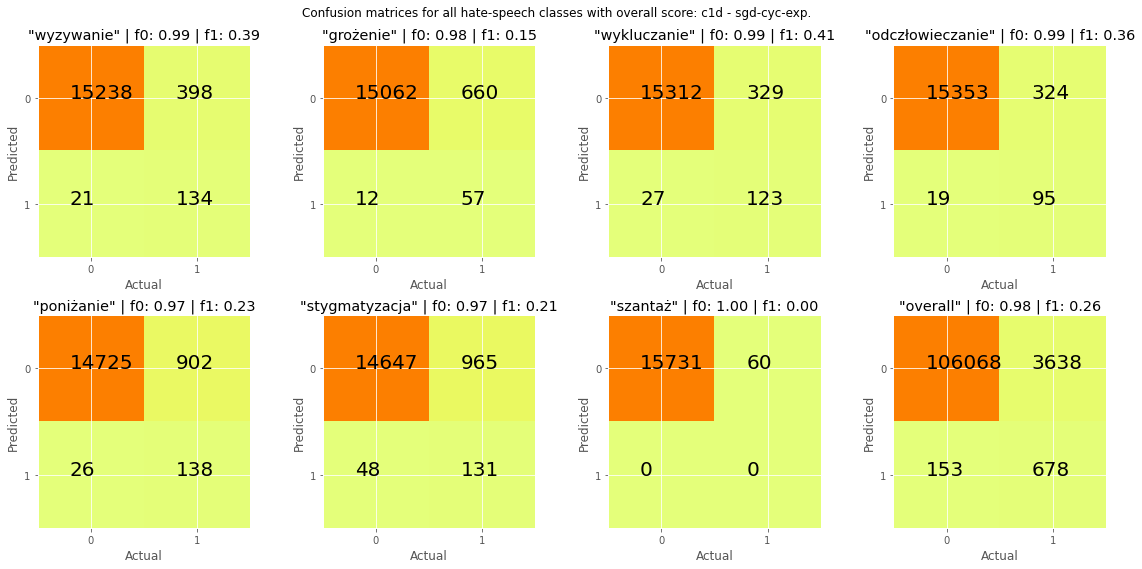

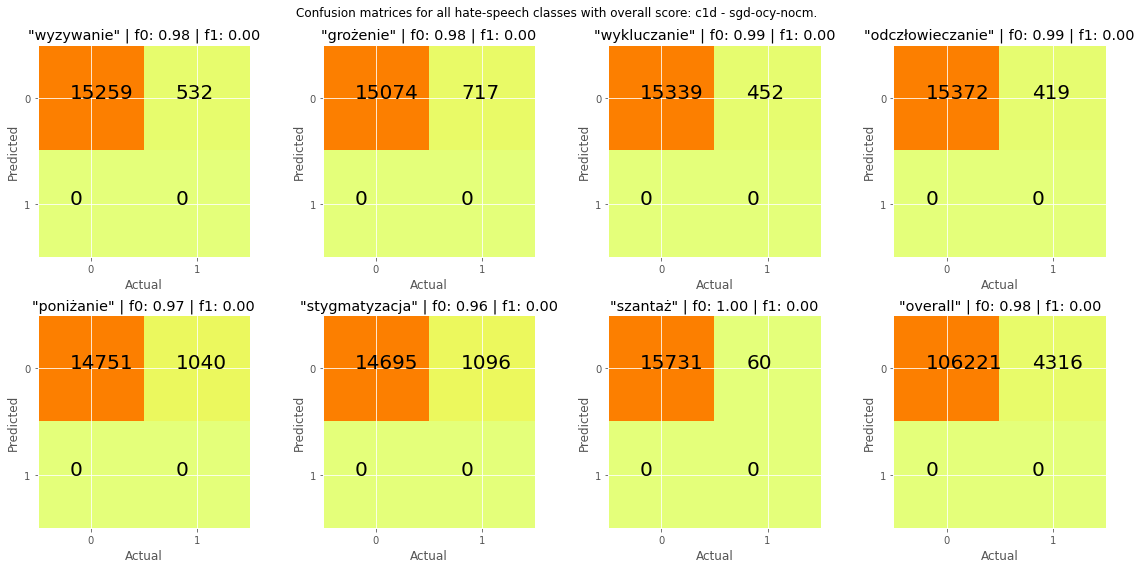

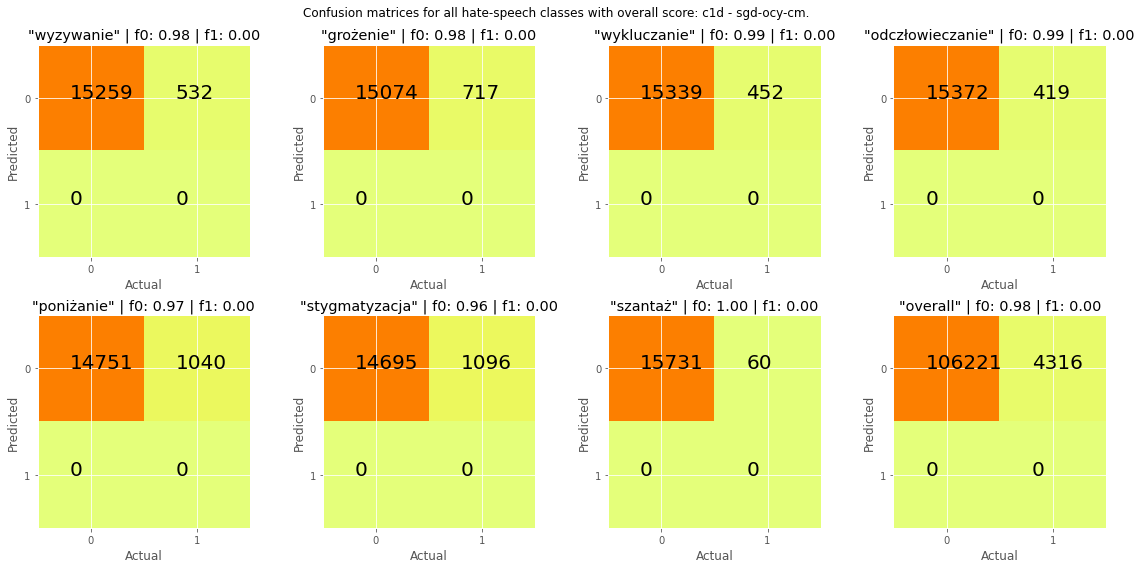

In [11]:
vkwargs = dict({'length': 50, 'model_type': 'cbow', 'short_name': 'CBoW'})
mkwargs = dict({'out_channels': 32, 'kernel_size': 3, 'n_convs': 2})
for hparams, hlabel in tqdm(zip(HYPERPARAMS, HYPERPARAM_LABELS), total=len(HYPERPARAM_LABELS), leave=False):
    clf = DLVectorClassifier(short_name=f'{mlabel}_{hlabel}', k_folds=5, weights=weights,
                             vec_class=WordPretrainedVectorizer, nn_class=Conv1dNet,
                             nn_type=f'hparams_conv1d_{wlabel}', nn_hparams=hparams,
                             vec_params=vkwargs, nn_params=mkwargs)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_data)
    confusion_matrices(y_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score: {mlabel} - {hlabel}.',
                       save_file=DLHP_CHART_DIR.replace('{}', f'{mlabel}_{wlabel}_confusion_matrices_{hlabel}'))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

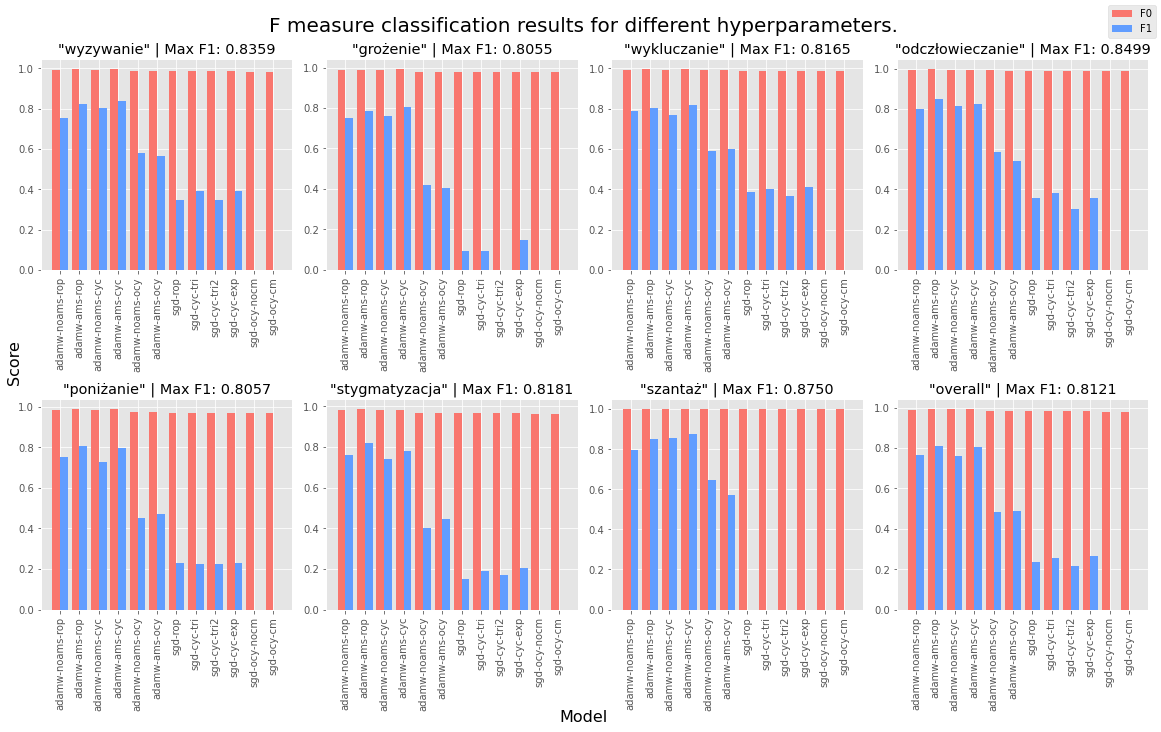

In [12]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=HYPERPARAM_LABELS,
                    title='F measure classification results for different hyperparameters.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=DLHP_CHART_DIR.replace('{}', f'{mlabel}_{wlabel}_models_F_bars'))

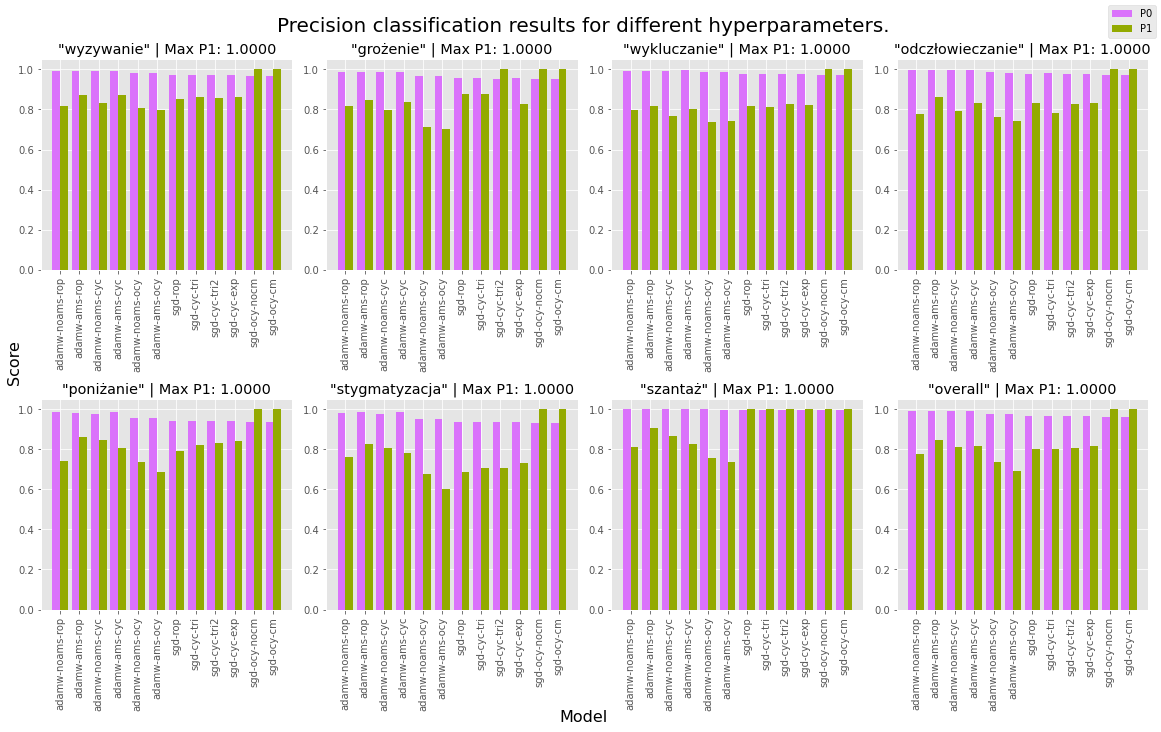

In [13]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=HYPERPARAM_LABELS,
                    title='Precision classification results for different hyperparameters.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=DLHP_CHART_DIR.replace('{}', f'{mlabel}_{wlabel}_models_P_bars'))

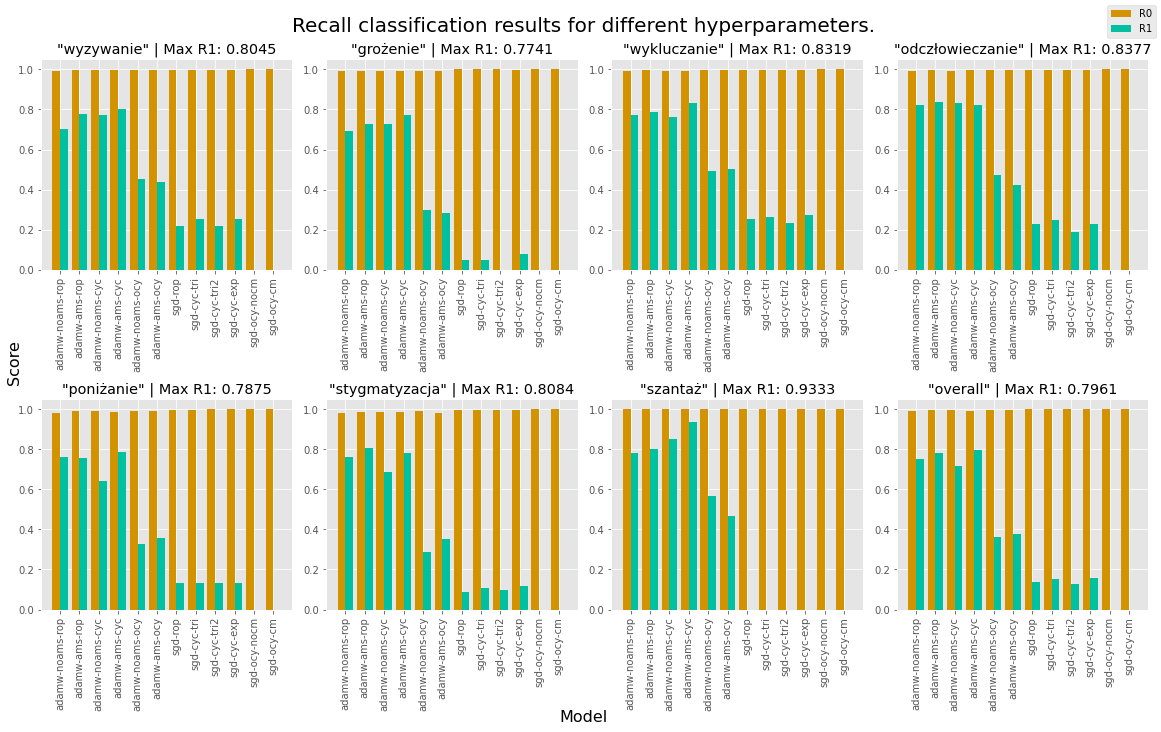

In [14]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=HYPERPARAM_LABELS,
                    title='Recall classification results for different hyperparameters.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=DLHP_CHART_DIR.replace('{}', f'{mlabel}_{wlabel}_models_R_bars'))

## Best recurrent NN model

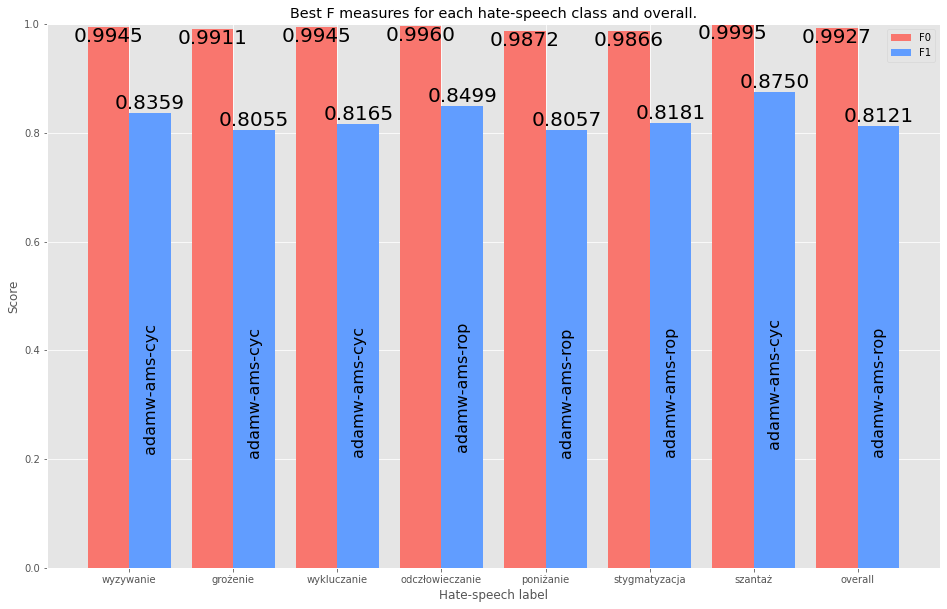

In [15]:
best_model_for_class(y_trues=y_data, y_preds_s=y_preds, model_names=HYPERPARAM_LABELS,
                     title='Best F measures for each hate-speech class and overall.',
                     save_file=DLHP_CHART_DIR.replace('{}', f'{mlabel}_{wlabel}_best_F_bars'))

Judging by the above analyses the best hyperparameters are **AdamW** optimizer **with AMSGrad** algorithm and **Reduce LR On Plateau** scheduler.

In [21]:
vkwargs = dict({'length': 50, 'model_type': 'cbow', 'short_name': 'CBoW'})
mkwargs = dict({'out_channels': 32, 'kernel_size': 3, 'n_convs': 2})
hparams = dict({'_epochs': 50, '_optim': torch.optim.AdamW, '_optim_params': dict({'amsgrad': True}),
                '_sched': torch.optim.lr_scheduler.ReduceLROnPlateau, '_sched_params': dict({'patience': 5, 'factor': 0.97}),})
clf = DLVectorClassifier(short_name=f'{mlabel}_adamw-ams-rop', k_folds=5,
                         vec_class=WordPretrainedVectorizer, nn_class=Conv1dNet,
                         nn_type=f'hparams_conv1d_{wlabel}', nn_hparams=hparams,
                         vec_params=vkwargs, nn_params=mkwargs)
clf.load()

## Training history

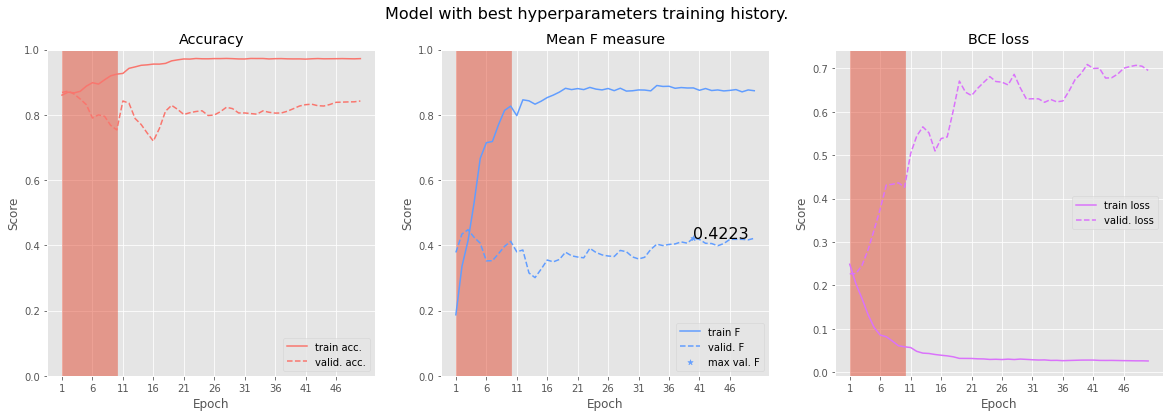

In [22]:
clf.plot_train_history_lines(title='Model with best hyperparameters training history.',
                             save_file=DLHP_CHART_DIR.replace('{}', f'{mlabel}_{wlabel}_best_history_lines'))

## Tests

### Test 1

In [23]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'stygmatyzacja' as positive.

### Test 2

In [24]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically labels: 'wyzywanie', 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' should be positive.

### Test 3

In [25]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'grożenie' as positive.